In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from sklearn.preprocessing import StandardScaler
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import from_networkx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x


def visibility_graph(data, value, window_size=30, step_size=1, batch_size=7):
    frames = []
    vis_frames = []
    targets = []
    values = data.values
    vis_col = data[value].tolist()
    l = len(data)

    for i in range(0, l, step_size):
        end = i + window_size
        if end > l:
            frames.append(values[l - window_size - 1 : l - 1])
            targets.append(values[l - 1])
            vis_frames.append(vis_col[l - window_size - 1 : l - 1])
            break

        frames.append(values[i:end])
        vis_frames.append(vis_col[i:end])
        targets.append(values[end])

    ll = len(frames)
    graphs = []
    for i in range(ll):
        frame = frames[i]
        vis = vis_frames[i]
        target = targets[i]
        G = nx.visibility_graph(vis)
        temp = from_networkx(G)
        edge_index = temp.edge_index
        x = torch.tensor(frame, dtype=torch.float)
        y = torch.tensor(target, dtype=torch.float)
        graph = Data(x=x, edge_index=edge_index, y=y)
        graphs.append(graph)

    return graphs

In [3]:
df = pd.read_csv("../nabil.csv")
cols = df.columns
scaler = StandardScaler()
data = scaler.fit_transform(df)
df = pd.DataFrame(data, columns=cols)

test_graphs = visibility_graph(data=df, value="open", window_size=30, step_size=20)

model = GCN(7, 64 , 7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('gcn.pth', map_location=device, weights_only=True))
model = model.to(device)

In [4]:
model.eval()
predictions = []
ground_truth = []
for batch in test_graphs:
    batch = batch.to(device)
    with torch.no_grad():
        output = model(batch.x, batch.edge_index, batch.batch)
        output = output.view(-1)
        predictions.append(output.cpu().numpy())
        ground_truth.append(batch.y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
ground_truth = np.concatenate(ground_truth, axis=0)

In [5]:
predictions = predictions.reshape(-1, 7)
ground_truth = ground_truth.reshape(-1, 7)

predictions = scaler.inverse_transform(predictions)
ground_truth = scaler.inverse_transform(ground_truth)
temp = pd.read_csv("../NABIL2.csv")
predictions = pd.DataFrame(predictions, columns=cols)
ground_truth = pd.DataFrame(ground_truth, columns=cols)
predictions['published_date'] = temp['published_date']
ground_truth['published_date'] = temp['published_date']

In [6]:
predictions

,open,high,low,close,per_change,traded_quantity,traded_amount,published_date
0,1190.831543,1214.460205,1135.268188,1189.298950,-0.885011,14376.492188,9362981.0,5/15/2011
1,1213.292358,1248.378174,1151.181519,1228.774780,-0.849878,3763.095459,1752237.0,5/16/2011
2,1030.517700,1037.176758,1004.118652,1018.180969,-0.272101,7293.115234,3258621.0,5/18/2011
3,956.015625,951.326416,946.500732,950.838318,1.468625,2631.421631,5449759.0,5/19/2011
4,920.123840,929.149231,897.995850,920.195435,0.479663,4475.269531,4924605.0,5/22/2011
...,...,...,...,...,...,...,...,...
151,542.726807,546.113892,535.800232,539.500366,-1.875752,115716.679688,60314732.0,1/23/2012
152,530.220520,526.684509,503.930542,504.352478,-1.047906,74991.640625,37283584.0,1/25/2012
153,567.092712,560.987000,552.146240,538.732483,-0.328823,71002.296875,38359976.0,1/26/2012
154,504.643402,512.977234,485.346497,478.400024,-0.772028,74730.703125,46169540.0,1/29/2012


In [7]:
ground_truth

,open,high,low,close,per_change,traded_quantity,traded_amount,published_date
0,1123.000000,1140.000000,1060.000000,1140.000000,1.51,1897.999756,2042371.0,5/15/2011
1,1294.000000,1305.000000,1276.000000,1289.000000,-0.39,577.999817,744983.0,5/16/2011
2,992.000000,999.000000,974.000000,990.000000,-0.20,1613.999756,1588177.0,5/18/2011
3,980.000000,982.000000,975.000000,982.000000,0.20,586.999817,572739.0,5/19/2011
4,875.000000,909.000000,892.000000,909.000000,3.89,23.999790,21645.0,5/22/2011
...,...,...,...,...,...,...,...,...
151,588.000000,592.000000,572.000000,573.000000,-2.22,93805.000000,54213108.0,1/23/2012
152,593.000000,601.000000,593.000000,600.000000,1.18,69441.000000,41603988.0,1/25/2012
153,560.000061,568.000000,557.000000,559.799988,-0.41,84892.000000,47657768.0,1/26/2012
154,501.799957,520.400024,501.799988,511.799988,-0.04,57475.000000,29470230.0,1/29/2012


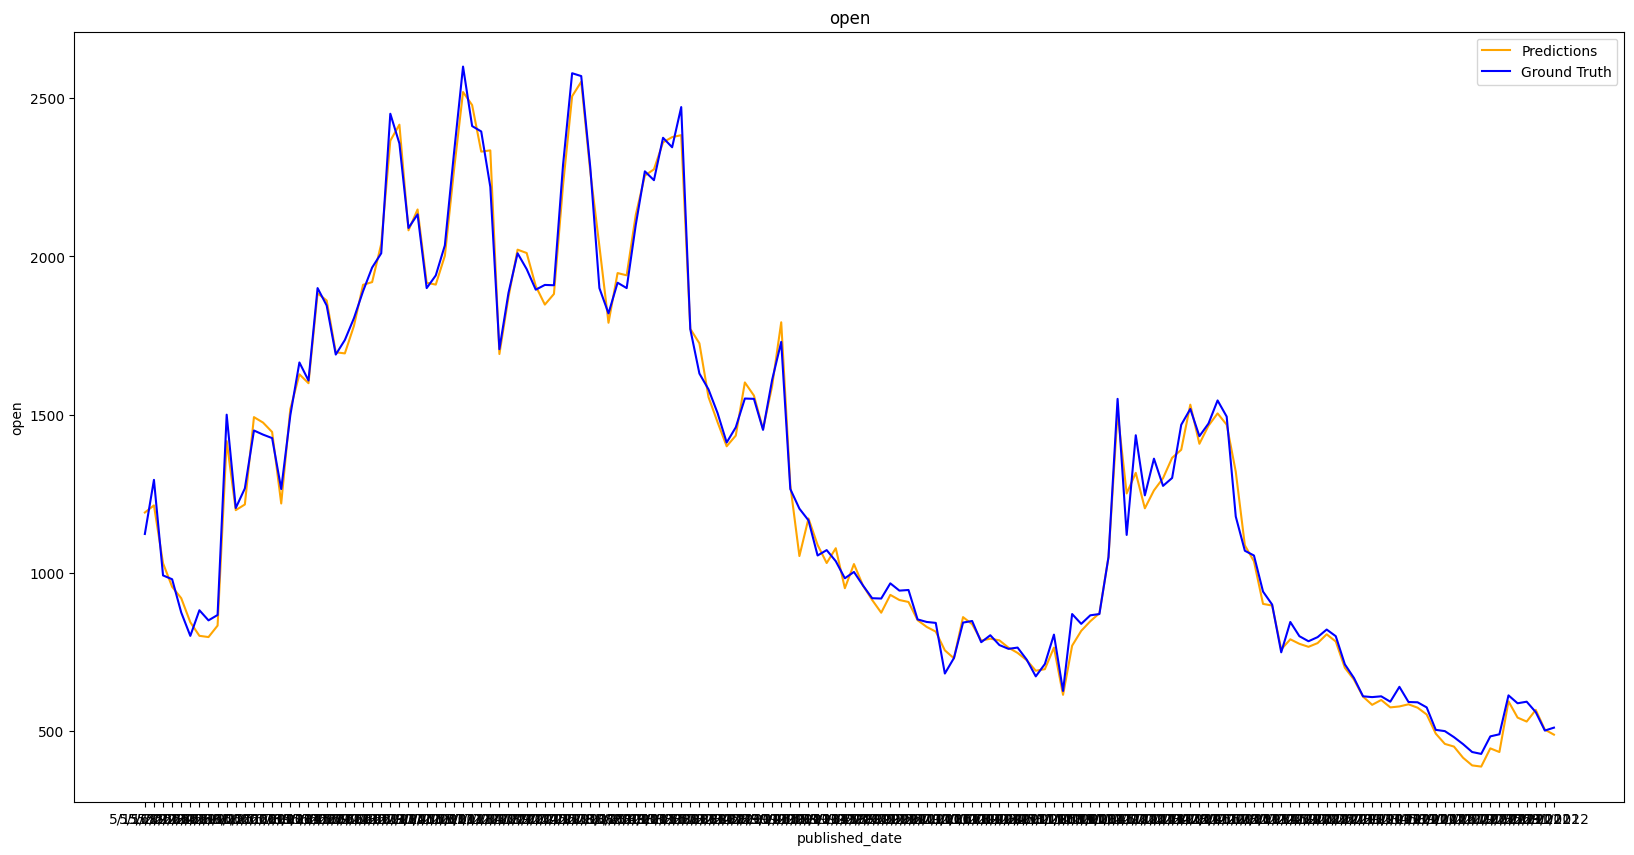

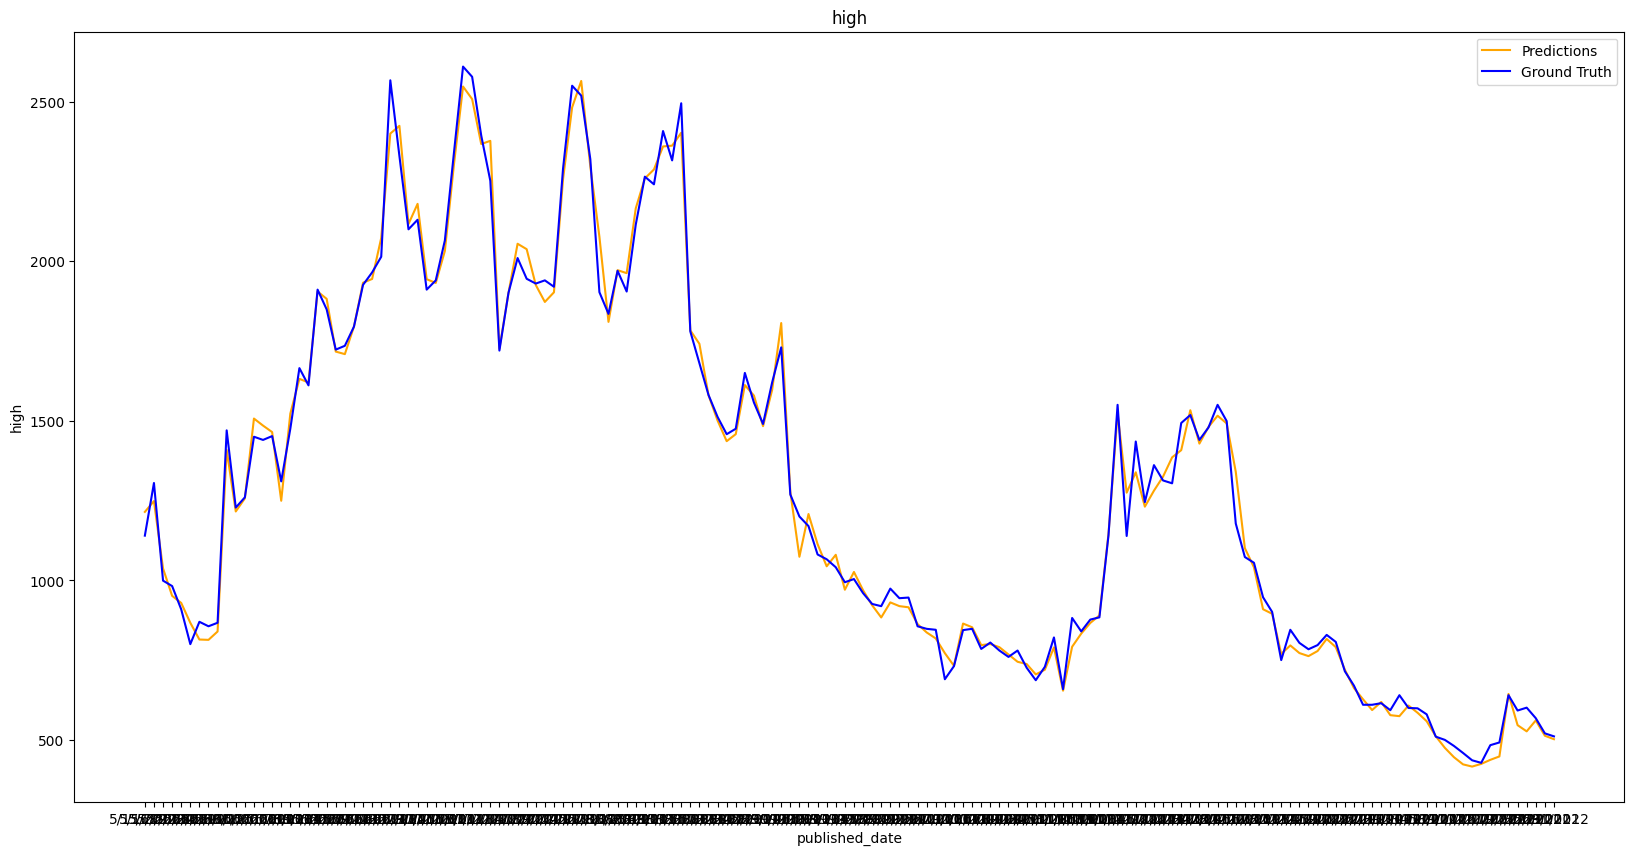

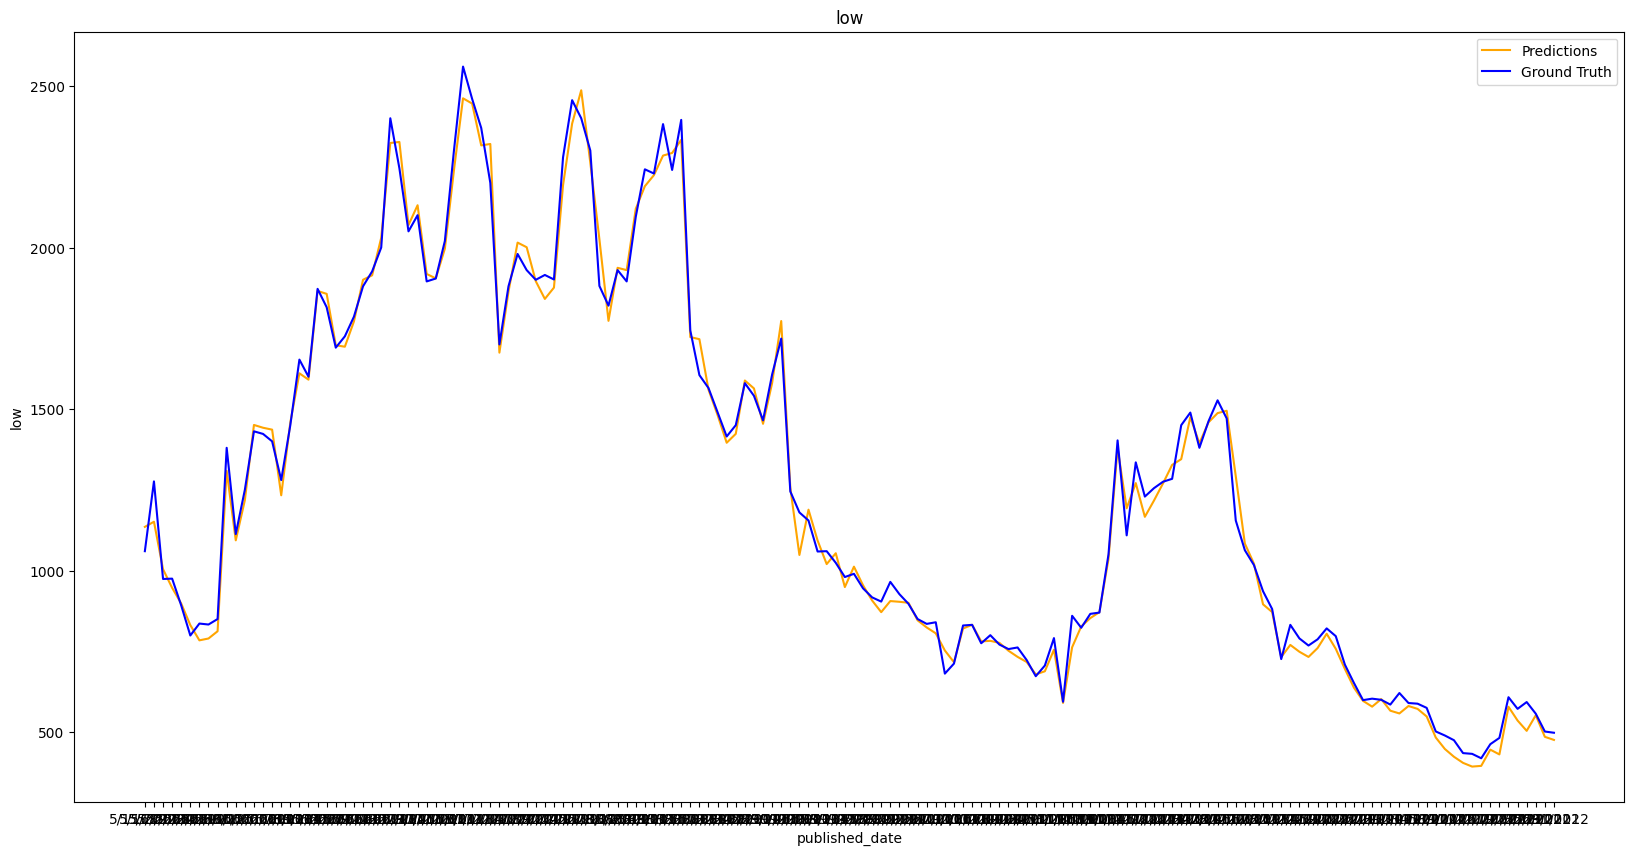

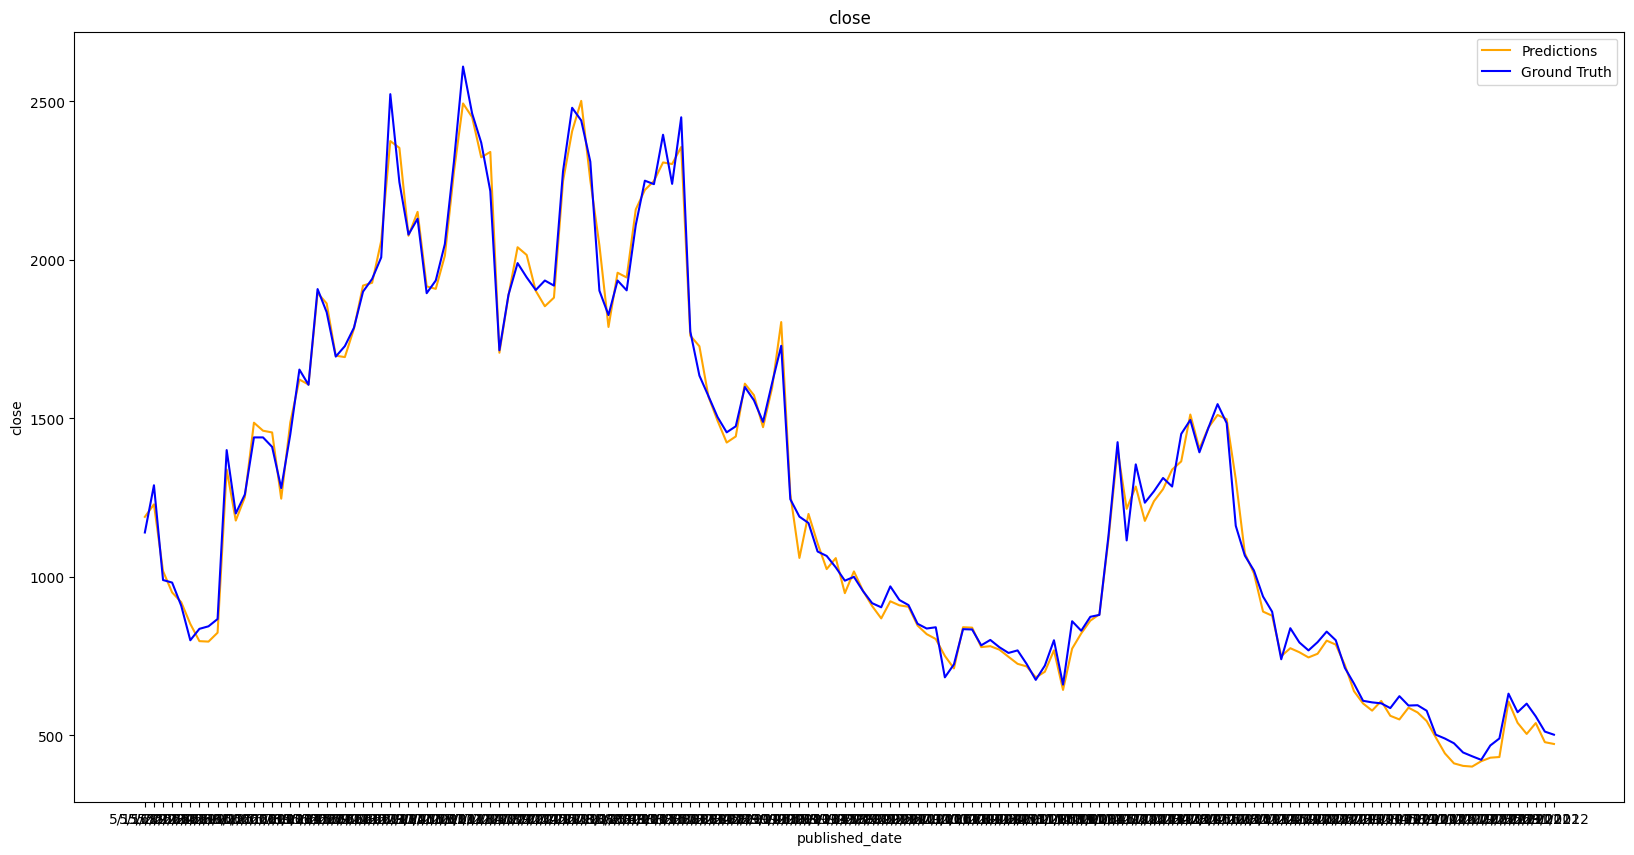

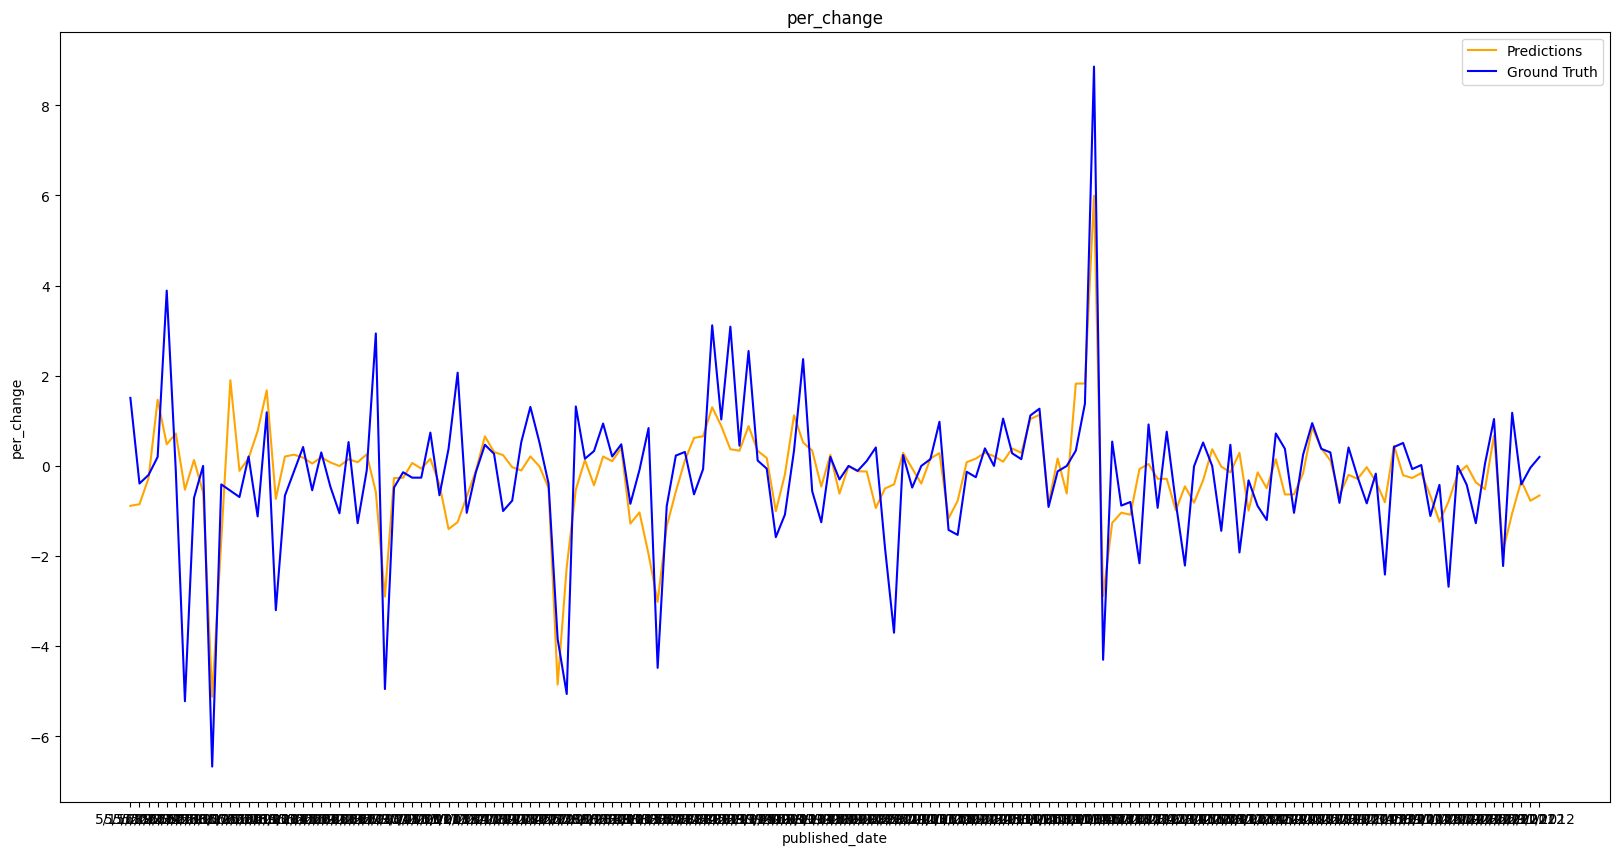

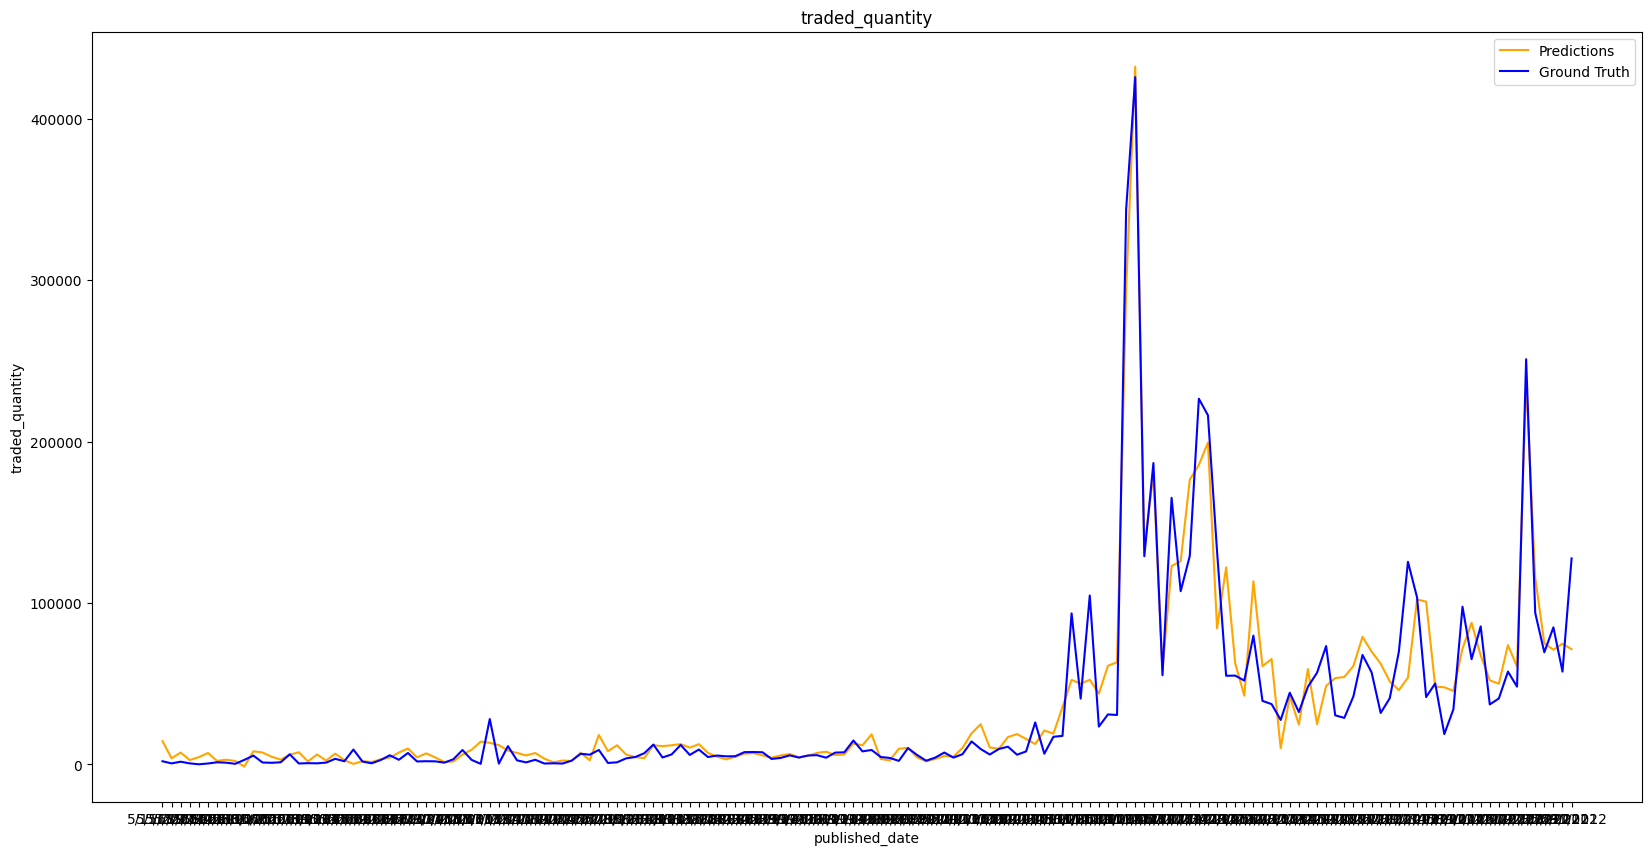

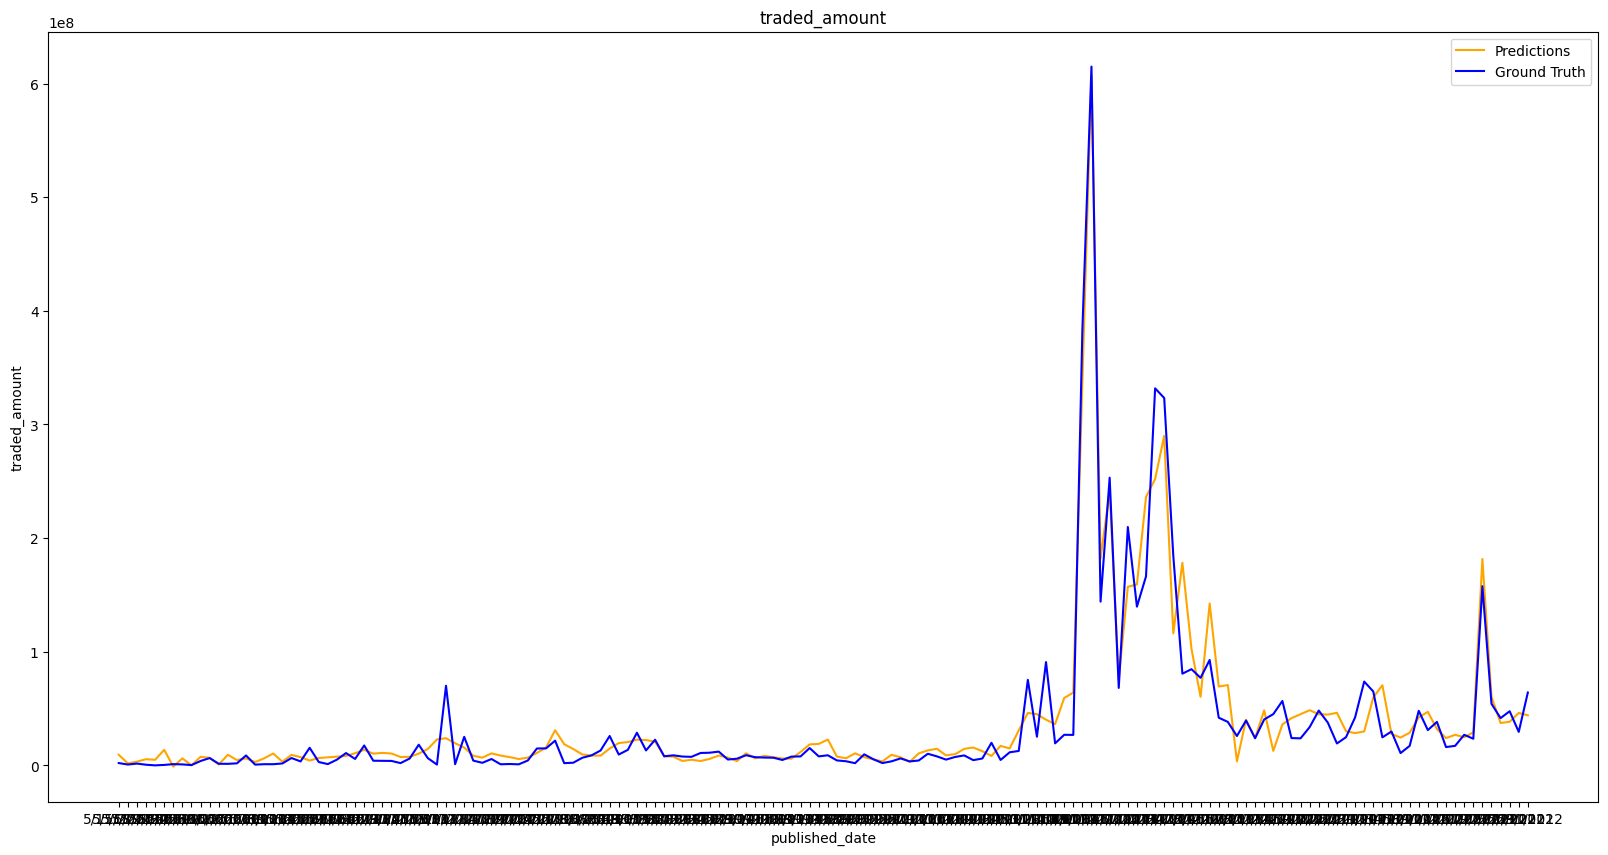

In [8]:
for col in cols:
    plt.figure(figsize=(20,10))
    sns.lineplot(predictions, x='published_date', y=col, color="orange", label="Predictions")
    sns.lineplot(ground_truth, x='published_date', y=col, color="blue", label="Ground Truth")
    plt.title(f"{col}")
    plt.show()